In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import warnings

from pathlib import Path

if not Path("images").exists():
    Path("images").mkdir(parents=True)
warnings.filterwarnings('ignore')

In [4]:
exp_full = pd.read_csv('../experiments/Altruism_RMAI_experiment2.csv', skiprows=[0, 1, 2, 3, 4, 5])
step_col = exp_full.pop("[step]")
exp_full.insert(1, "step", step_col)
exp_full = exp_full.rename(columns={"[run number]": "run-number"}).sort_values(by=['run-number', 'step'])
exp_full.head(10)

,run-number,step,occupation-var,initial-patch-harshness,prob-gain-resource,stride-length,agent-move-cost,energy-gain,altruism-resource-threshold,reproduction-var,initial-patch-resource,initial-population,initial-agent-energy,altruism-prob,repeat-diffusion,count altruism-agents,count greedy-agents
0,1,0,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,42,58
17,1,1,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,42,58
21,1,2,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,84,116
32,1,3,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,84,116
44,1,4,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,84,116
55,1,5,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,84,116
68,1,6,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,168,230
80,1,7,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,168,230
92,1,8,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,168,232
99,1,9,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,168,232


In [5]:
COLS_TO_OMIT = ['run-number', 'step', 'count altruism-agents', 'count greedy-agents']

summary = exp_full.describe().T
summary

,count,mean,std,min,25%,50%,75%,max
run-number,1361373.0,6740.584403,3892.056324,1.00,3370.00,6740.0,10110.0,13500.0
step,1361373.0,49.986521,29.157782,0.00,25.00,50.0,75.0,100.0
occupation-var,1361373.0,0.499379,0.257921,0.10,0.30,0.5,0.7,0.9
initial-patch-harshness,1361373.0,27.478953,14.360629,5.00,15.00,25.0,40.0,50.0
prob-gain-resource,1361373.0,0.600170,0.282812,0.20,0.40,0.6,0.8,1.0
stride-length,1361373.0,0.193338,0.167470,0.01,0.05,0.2,0.3,0.5
agent-move-cost,1361373.0,10.000000,0.000000,10.00,10.00,10.0,10.0,10.0
energy-gain,1361373.0,50.000000,0.000000,50.00,50.00,50.0,50.0,50.0
altruism-resource-threshold,1361373.0,20.000000,0.000000,20.00,20.00,20.0,20.0,20.0
reproduction-var,1361373.0,0.500000,0.000000,0.50,0.50,0.5,0.5,0.5


## Filter down to end states


In [6]:
exp = exp_full[exp_full["step"] == exp_full.groupby(['run-number'])['step'].transform('max')]
exp.head(10)

,run-number,step,occupation-var,initial-patch-harshness,prob-gain-resource,stride-length,agent-move-cost,energy-gain,altruism-resource-threshold,reproduction-var,initial-patch-resource,initial-population,initial-agent-energy,altruism-prob,repeat-diffusion,count altruism-agents,count greedy-agents
997,1,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,2608,7666
992,2,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,2814,6675
983,3,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,3129,6618
999,4,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,3544,6210
1008,5,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,3296,6409
989,6,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,2562,6760
1065,7,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,3227,7260
1004,8,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,3555,6735
1013,9,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,3927,5699
1010,10,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,3242,6821


In [7]:
exp = exp[exp['step'] == 100].drop(columns=['step'])


In [8]:
varying_inputs = [i for i in summary.index if summary.loc[i]['min'] != summary.loc[i]['max'] and i not in COLS_TO_OMIT]
varying_inputs

['occupation-var',
 'initial-patch-harshness',
 'prob-gain-resource',
 'stride-length']

In [9]:
exp['altruism_ratio'] = exp['count altruism-agents'] / (exp['count altruism-agents'] + exp['count greedy-agents'])
exp = exp.drop(columns=['count altruism-agents', 'count greedy-agents']).set_index('run-number')
y = exp.pop('altruism_ratio')
X = exp[varying_inputs]

In [13]:
def run_regression_analysis(X, y, title):
        # Standardizing the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Setting up cross-validation (e.g., 5-fold cross-validation)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    # Evaluating the model's performance with cross-validation
    model = LinearRegression()
    cv_scores = cross_validate(model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error', return_estimator=True)
    
    # Printing cross-validation results
    print(f"Mean Squared Error for each fold: {-cv_scores['test_score']}")
    print(f"Average Mean Squared Error: {-np.mean(cv_scores['test_score'])}")
    
    # Training the model on the entire dataset for interpretation
    model.fit(X_scaled, y)
    
    # Analyzing feature importance (coefficients)
    coefficients = model.coef_
    features = X.columns
    
    # Sorting the coefficients by their absolute values but keeping the sign
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    sorted_features = features[sorted_indices]
    sorted_coefficients = coefficients[sorted_indices]
    
    print("Feature Coefficients from Most to Least Important after Normalization:")
    for feature, coef in zip(sorted_features, sorted_coefficients):
        print(f"{feature}: {coef}")
    
    # Plotting the sorted coefficients for visual comparison
    plt.figure(figsize=(10, 2))
    plt.barh(sorted_features, sorted_coefficients)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

Sorted Feature Coefficients in Linear Regression after Normalization

Mean Squared Error for each fold: [0.00680192 0.00635056 0.00578201 0.00630445 0.0063873 ]
Average Mean Squared Error: 0.006325246549292144
Feature Coefficients from Most to Least Important after Normalization:
occupation-var: 0.0020180289293793177
initial-patch-harshness: 0.0007083283950890659
stride-length: 0.00021910311378056644
prob-gain-resource: -0.00018305640241099877


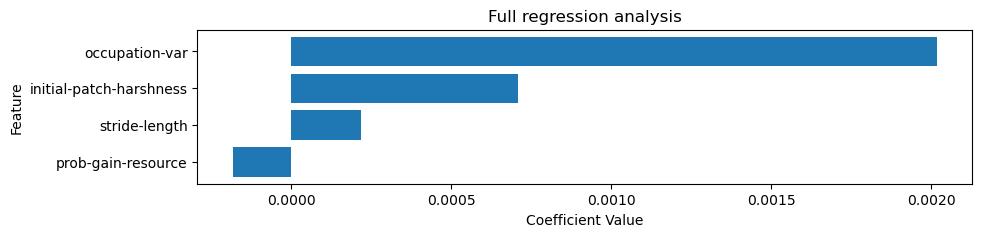

In [14]:
run_regression_analysis(X, y, "Full regression analysis")

#### Filter out runs where altruists die and run again

Mean Squared Error for each fold: [0.00583937 0.00636124 0.00579121 0.00619211 0.00601868]
Average Mean Squared Error: 0.006040522975409345
Feature Coefficients from Most to Least Important after Normalization:
occupation-var: 0.0031995276442284295
initial-patch-harshness: 0.0012585133509097216
prob-gain-resource: -0.00040133038802580217
stride-length: 0.00040087838938499313


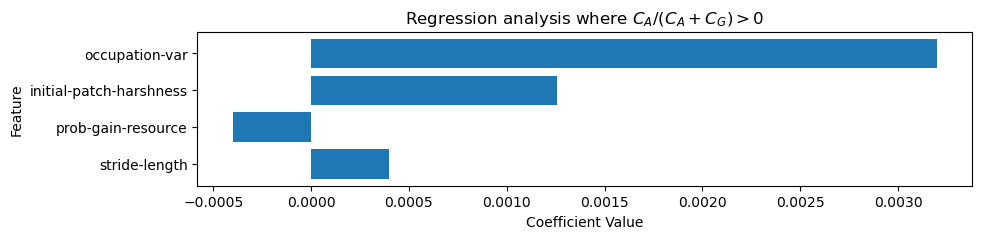

In [15]:
X_survive = X[y != 0]
y_survive = y[y != 0]

run_regression_analysis(X_survive, y_survive, r"Regression analysis where $C_A/(C_A+C_G) > 0$")